In [1]:
import os
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
from dataset import getAllDataPath, CustomImageDataset, show_image
from unet import UNet

In [3]:
BATCH_SIZE = 12
WIDTH = 256
HEIGHT = 256
device = 'cuda:0'

In [4]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/
transform = A.Compose([
    A.CenterCrop(300, 900, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
    A.Rotate((-10, 10), interpolation=0),  

    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([
    A.Resize(WIDTH, HEIGHT),
])

In [5]:
path = os.getcwd()
img_dir = f'{path}/data/capsule/test/scratch/'
anno_dir = f'{path}/data/capsule/ground_truth/scratch/'

defective_number = [i.split('.')[0] for i in os.listdir(img_dir)]
print('defective_number: ',defective_number)
data = getAllDataPath(img_dir, anno_dir, test_split_size=0.2)
print(data.keys())
data['train'] = data['train'][:2]
print(data['train'])


# In[57]:
# 在這邊會強制對所有不滿BATCH_SIZE的訓練資料做數量上的匹配(單純把路徑複製貼上直到滿足16筆資料)，接著透過CustomImageDataset的transform對16筆資料做資料擴增
if len(data['train']) < 16: 
    lis = data['train']
    lis = [lis[i%len(lis)] for i in range(BATCH_SIZE)]
    data['train'] = lis

dataset_train = CustomImageDataset(data['train'], transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, drop_last=True,
                                               shuffle=True, pin_memory=True,
                                              )

dataset_test = CustomImageDataset(data['test'], transform=target_transform) # **如果要正式使用要記得把這裡換成X_test
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, drop_last=False,
                                              shuffle=False, pin_memory=True)

defective_number:  ['020', '007', '006', '010', '003', '000', '019', '013', '017', '008', '022', '014', '016', '004', '009', '002', '012', '005', '015', '001', '018', '011', '021']
dict_keys(['train', 'test'])
[('/home/jovyan/Image_Segmentation/05_Datasets/MVTec_anomaly_detection/data/capsule/test/scratch/009.png', '/home/jovyan/Image_Segmentation/05_Datasets/MVTec_anomaly_detection/data/capsule/ground_truth/scratch/009_mask.png'), ('/home/jovyan/Image_Segmentation/05_Datasets/MVTec_anomaly_detection/data/capsule/test/scratch/005.png', '/home/jovyan/Image_Segmentation/05_Datasets/MVTec_anomaly_detection/data/capsule/ground_truth/scratch/005_mask.png')]


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
tensor([0.0588, 0.0627, 0.0667, 0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902,
        0.0941, 0.0980, 0.1020, 0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255,
        0.1294, 0.1333, 0.1373, 0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608,
        0.1647, 0.1686, 0.1725, 0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961,
        0.2000, 0.2039, 0.2078, 0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314,
        0.2353, 0.2392, 0.2431, 0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667,
        0.2706, 0.2745, 0.2784, 0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020,
        0.3059, 0.3098, 0.3137, 0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373,
        0.3412, 0.3451, 0.3490, 0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725,
        0.3765, 0.3804, 0.3843, 0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078,
        0.4118, 0.4157, 0.4196, 0.4235, 0.4275, 0.4314, 0.4353, 0.4392, 0.4431,
        0.4471, 0.4510, 0.4549, 0.4588, 0.4627, 0.4667, 0.4706, 0.47

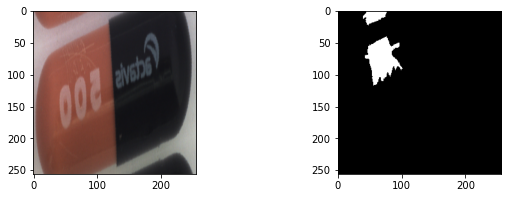

In [6]:
'''
Abs: test transform on dataloader_train.
---
take first image in every batch.
'''
for data in dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        print(x.unique(), y.unique())
        show_image(x.permute(1,2,0).numpy(), y.squeeze(0).numpy())
        break 

In [7]:
import torch
import torch.nn as nn
 
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
 
    def	forward(self, input, target):
        N = target.size(0)
        smooth = 1
 
        input_flat = input.view(N, -1)
        target_flat = target.view(N, -1)
 
        intersection = input_flat * target_flat
 
        loss = (2 * intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
        loss = 1 - loss.sum() / N
 
        return loss


In [8]:
model = UNet

In [9]:
from torchvision.ops import sigmoid_focal_loss
'''
abs: single channel
---
單一通道，二元分類輸出範例
補充:
- 要在建立optimizer之前就把model的參數移到gpu裡面 
ref: https://pytorch.org/docs/stable/optim.html 
'''
model = model(HEIGHT, in_ch=3, out_ch=1, activation=None).to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-1)

In [10]:
# '''
# abs: Multi channel
# ---
# 輸出多通道，多元分類輸出範例
# 補充:
# - 要在建立optimizer之前就把model的參數移到gpu裡面 

# ref: https://pytorch.org/docs/stable/optim.html 
# '''
# criterion = nn.CrossEntropyLoss().to(device)

# model = model(HEIGHT, in_ch=3, out_ch=2, activation=nn.Sigmoid()).to(device) 

# optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
'''
abs: training model
---
- 下面的程序會在3種條件下儲存當前的model(只包含weight)
    - 當前模型的loss是目前以來最低
    - 當前epoch數是20的倍數
    - 完成一個epoch的訓練
'''
EPOCHS = 300
min_target_loss_value = 100
save_root = './data/save_weights/'
os.makedirs(save_root, exist_ok=True)
from torchvision.ops import sigmoid_focal_loss

for epoch in range(EPOCHS):  
    class_loss_value = 0.0

    for i, (source_data, source_label) in enumerate(dataloader_train):
        # zero the parameter gradients
        '''
        abs: zero the parameter gradients
        ---
        這兩種方法都能夠清除variable內的gradient:
        方法1
        param in model.parameters():
        param.grad = None
        方法2 借助optimizer尋找關聯的variable並清除gradient
        optimizer.zero_grad()
        '''
        optimizer.zero_grad()
    
        source_data = source_data.to(device)
        source_label = source_label.to(device)

        outputs = model(source_data)
        
#         loss = DiceLoss()(outputs, source_label)
#         loss = torch.nn.MSELoss()(outputs, source_label)
#         loss = torch.nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([100]).to(device))(outputs, source_label)
        loss = sigmoid_focal_loss(outputs, source_label, reduction='sum')
        
        class_loss_value += loss.item()

        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(i, end='\r')
        del source_data, source_label, outputs
        torch.cuda.empty_cache()

    class_loss_value /= (i+1)   
    testing_loss_value = class_loss_value

    print(f'epoch: {epoch}, class_loss_value:{class_loss_value}')
    if testing_loss_value < min_target_loss_value:
        min_target_loss_value = testing_loss_value
        print('save best model')
        torch.save(model.state_dict(), f'{save_root}best_model.bin')
    else:
        if epoch%50==49:
            torch.save(model.state_dict(), f'{save_root}E{epoch}_model.bin')
        torch.save(model.state_dict(), f'{save_root}model.bin')
        

epoch: 0, class_loss_value:162817.03125
epoch: 1, class_loss_value:57682.9375
epoch: 2, class_loss_value:5617.9775390625
epoch: 3, class_loss_value:8654.9462890625
epoch: 4, class_loss_value:8949.4609375
epoch: 5, class_loss_value:5439.7919921875
epoch: 6, class_loss_value:10292.927734375
epoch: 7, class_loss_value:6265.6884765625
epoch: 8, class_loss_value:6425.5068359375
epoch: 9, class_loss_value:7048.85595703125
epoch: 10, class_loss_value:8829.31640625
epoch: 11, class_loss_value:7819.9453125
epoch: 12, class_loss_value:6896.92724609375
epoch: 13, class_loss_value:5166.09912109375
epoch: 14, class_loss_value:8043.9462890625
epoch: 15, class_loss_value:4039.908203125
epoch: 16, class_loss_value:5814.70703125
epoch: 17, class_loss_value:6187.3984375
epoch: 18, class_loss_value:4979.072265625
epoch: 19, class_loss_value:5763.283203125
epoch: 20, class_loss_value:5107.326171875
epoch: 21, class_loss_value:3438.900146484375
epoch: 22, class_loss_value:4571.3115234375
epoch: 23, class_l

In [ ]:
model = UNet
model = model(HEIGHT, in_ch=3, out_ch=1, activation=None).to(device)
save_root = './data/save_weights/'
filepath = f'{save_root}model.bin'
model.load_state_dict(torch.load(filepath)) 

In [ ]:
'''
abs: testing model
---
'''

for i, data in enumerate(dataloader_test, 1):
    image, mask = data
    print(len(image), image.shape, mask.shape)
    with torch.no_grad():
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)
#         outputs = F.sigmoid(outputs)
    loss = DiceLoss()(outputs, mask)
    print(outputs.unique())
#     threshold = 0
#     outputs[outputs>=threshold] = 1.
#     outputs[outputs!=1] = 0.

    img_process = lambda image:image.permute(0,2,3,1).cpu().numpy()
    mask_process = lambda mask:mask.squeeze(1).cpu().numpy()
    
    for x, m, outputs in zip(img_process(image), mask_process(mask), mask_process(outputs)):
        show_image(x, m, outputs)
    del outputs, image, mask
#         break

In [ ]:
import os
from IPython import get_ipython
if __name__ == '__main__':
    if get_ipython().__class__.__name__ =='ZMQInteractiveShell':
        os.system('jupyter nbconvert train_unet.ipynb --to python')